In [47]:
fidx = 'resnet'
midx = '4'

mnames = ['resnet34_46','resnet50','resnet34','resnet_a8','resnet_a11']
weights = [1,1,1,1,1]

threshold = 0
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)

resnet 4 0 20


In [48]:
klist = ['resnet34_46','resnet50','resnet34']
print(klist)

['resnet34_46', 'resnet50', 'resnet34']


In [49]:
# results from ens_oof.ipynb
assert(len(mnames)==len(weights))
# mname = 'se_resnext_a2'
# print(mname,mnames,weights)

In [50]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [51]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [52]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [53]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [54]:
test_df.columns

Index(['Predicted'], dtype='object')

In [55]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [56]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    ptestb = logit(ptestb)
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                
                ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/resnet34_46_0.pkl
-20.0 -3.459926 6.296183
(11702, 28) -20.0 -3.459926 6.296183

./sub/resnet34_46_1.pkl
-20.0 -3.3344078 6.165884
(11702, 28) -20.0 -3.3344078 6.165884
[[1.    0.955]
 [0.955 1.   ]]

./sub/resnet34_46_2.pkl
-20.0 -3.315843 4.956825
(11702, 28) -20.0 -3.315843 4.956825
[[1.    0.969]
 [0.969 1.   ]]

./sub/resnet34_46_3.pkl
-20.0 -3.3026276 6.137777
(11702, 28) -20.0 -3.3026276 6.137777
[[1.    0.972]
 [0.972 1.   ]]

./sub/resnet34_46_4.pkl
-20.0 -3.3562124 5.5849032
(11702, 28) -20.0 -3.3562124 5.5849032
[[1.    0.972]
 [0.972 1.   ]]

./sub/resnet34_46_5.pkl
-20.0 -3.3033059 5.4589205
(11702, 28) -20.0 -3.3033059 5.4589205
[[1.    0.973]
 [0.973 1.   ]]

./sub/resnet34_46_6.pkl
-20.0 -3.2824593 5.0698414
(11702, 28) -20.0 -3.2824593 5.0698414
[[1.    0.975]
 [0.975 1.   ]]

./sub/resnet34_46_7.pkl
-20.0 -3.3827417 5.4176774
(11702, 28) -20.0 -3.3827417 5.4176774
[[1.    0.973]
 [0.973 1.   ]]

./sub/resnet34_46_8.pkl
-20.0 -3.3863935 6.9515476
(11702, 28) -20

In [57]:
test_df.columns

Index(['Predicted', 'resnet34_46', 'resnet50', 'resnet34', 'resnet_a8',
       'resnet_a11'],
      dtype='object')

In [58]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [59]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
print(np.corrcoef(f))   

['resnet34_46', 'resnet50', 'resnet34', 'resnet_a8', 'resnet_a11']
[[1.    0.978 0.944 0.901 0.863]
 [0.978 1.    0.944 0.894 0.857]
 [0.944 0.944 1.    0.893 0.873]
 [0.901 0.894 0.893 1.    0.841]
 [0.863 0.857 0.873 0.841 1.   ]]


In [60]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 5)
flat.csv


In [61]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(5, 11702, 28)


In [62]:
weights = np.array(weights)
print(weights)

[1 1 1 1 1]


In [63]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [64]:
print(ens[1])

[-1.146 -2.797 -1.97  -0.83  -2.337  1.103 -1.    -2.194 -3.213 -5.05  -5.065 -1.502 -2.347 -2.318
 -2.375 -3.407 -2.288 -2.759 -1.992 -1.559 -2.98  -1.836 -2.184 -1.019 -2.323 -0.593 -2.187 -4.118]


In [65]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [66]:
# desired class proportions from lb probing
eps = 0.01
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.01, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.01, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.01, 25: 0.222493888, 26: 0.028806584, 27: 0.01}


In [67]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0
0 0.3624 0.4664 Nucleoplasm
1 0.0438 0.0349 Nuclear membrane
2 0.0753 0.0978 Nucleoli
3 0.0593 0.0278 Nucleoli fibrillar center
4 0.0753 0.0350 Nuclear speckles
5 0.0753 0.0477 Nuclear bodies
6 0.0438 0.0195 Endoplasmic reticulum
7 0.0753 0.0668 Golgi apparatus
8 0.0100 0.0003 Peroxisomes
9 0.0100 0.0003 Endosomes
10 0.0100 0.0002 Lysosomes
11 0.0438 0.0284 Intermediate filaments
12 0.0438 0.0164 Actin filaments
13 0.0142 0.0088 Focal adhesion sites
14 0.0438 0.0372 Microtubules
15 0.0100 0.0000 Microtubule ends
16 0.0288 0.0077 Cytokinetic bridge
17 0.0142 0.0067 Mitotic spindle
18 0.0288 0.0149 Microtubule organizing center
19 0.0593 0.0320 Centrosome
20 0.0100 0.0013 Lipid droplets
21 0.1261 0.1473 Plasma membrane
22 0.0288 0.0145 Cell junctions
23 0.0753 0.0791 Mitochondria
24 0.0100 0.0085 Aggresome
25 0.2225 0.3236 Cytosol
26 0.0288 0.0074 Cytoplasmic bodies
27 0.0100 0.0000 Rods & rings


In [68]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.622 0.36  0.61  0.309 0.28  0.408 0.33  0.467 0.122 0.112 0.104 0.349 0.271 0.375 0.418 0.115
 0.31  0.38  0.425 0.375 0.234 0.533 0.358 0.52  0.44  0.569 0.256 0.101]
Fractions:  [0.363 0.043 0.075 0.057 0.072 0.073 0.042 0.075 0.005 0.004 0.003 0.043 0.042 0.014 0.044 0.002
 0.026 0.014 0.028 0.058 0.009 0.125 0.028 0.075 0.01  0.222 0.026 0.001]
Fractions (th = 0.5):  [0.466 0.035 0.098 0.028 0.035 0.048 0.019 0.067 0.    0.    0.    0.028 0.016 0.009 0.037 0.
 0.008 0.007 0.015 0.032 0.001 0.147 0.015 0.079 0.009 0.324 0.007 0.   ]


In [69]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5, -5, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5034 0.3624 0.3624 Nucleoplasm
1 -0.5960 0.0438 0.0439 Nuclear membrane
2 0.4451 0.0753 0.0753 Nucleoli
3 -0.8386 0.0593 0.0594 Nucleoli fibrillar center
4 -0.9807 0.0753 0.0753 Nuclear speckles
5 -0.3930 0.0753 0.0753 Nuclear bodies
6 -0.7377 0.0438 0.0439 Endoplasmic reticulum
7 -0.1352 0.0753 0.0753 Golgi apparatus
8 -2.4239 0.0100 0.0102 Peroxisomes
9 -2.6634 0.0100 0.0101 Endosomes
10 -3.1465 0.0100 0.0101 Lysosomes
11 -0.6601 0.0438 0.0439 Intermediate filaments
12 -1.0301 0.0438 0.0439 Actin filaments
13 -0.5313 0.0142 0.0143 Focal adhesion sites
14 -0.3282 0.0438 0.0439 Microtubules
15 -2.6156 0.0100 0.0101 Microtubule ends
16 -0.8429 0.0288 0.0289 Cytokinetic bridge
17 -0.5095 0.0142 0.0143 Mitotic spindle
18 -0.3234 0.0288 0.0289 Microtubule organizing center
19 -0.5290 0.0593 0.0594 Centrosome
20 -1.2382 0.0100 0.0101 Lipid droplets
21 0.1186 0.1261 0.1261 Plasma membrane
22 -0.6105 0.0288 0.0289 Cell junctions
23 0.0698 0.0753 0.0753 Mitochondria
24 -0.2475 0.0100 0.010

In [70]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [71]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.640659716287814 7.0


In [72]:
print(sum(xps==0)/pred.shape[0])

0.05076055375149547


In [73]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1 5
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '3 5', '0 5 25', '0', '23', '4', '4 

In [74]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/resnet4.csv


In [75]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 119 prop 0.0102
9 Endosomes count 118 prop 0.0101
10 Lysosomes count 118 prop 0.0101
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 118 prop 0.0101
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 118 prop 0.0101
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome coun

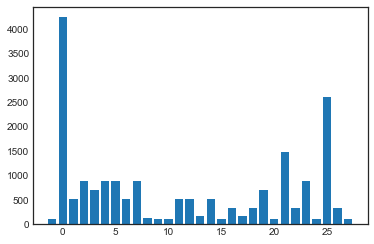

In [76]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [77]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [78]:
f1_sub(fname,'sub/protein_classification.csv')

0.764550262807543

In [79]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5672170591130907

In [80]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5505950301316449

In [81]:
f1_sub(fname,'sub/se_resnext6.csv')

0.684176986864937

In [82]:
f1_sub(fname,'sub/iv3_0.csv')

0.6695899980352956

In [83]:
f1_sub(fname,'sub/irv2_0.csv')

0.6946601565401511

In [84]:
f1_sub(fname,'sub/ens0.csv')

0.7246840088117853

In [85]:
f1_sub(fname,'sub/ens1.csv')

0.7967683567461493

In [86]:
f1_sub(fname,'sub/ens2.csv')

0.7910623640964253

In [87]:
f1_sub(fname,'sub/resnet34_0.csv')

0.7996944067839422

In [88]:
f1_sub(fname,'sub/resnet50_0.csv')

0.7890680070375843

In [89]:
f1_sub('sub/resnet34_0.csv','sub/resnet50_0.csv')

0.8280601477531034

In [90]:
print(fname)

sub/resnet4.csv
